# Food Delivery Market Analysis

## 1. Overview
This notebook explores food delivery marketplace data to uncover pricing patterns, geographic coverage, and value opportunities across restaurants. The analysis is designed to support data-driven insights for restaurant partners and platform stakeholders.

In [ ]:
# Quick data checks

import sqlite3
import pandas as pd

conn = sqlite3.connect("takeaway.db")

# tables: locations_to_restaurants, locations, categories_restaurants, restaurants, menuItems, categories
pd.read_sql("""
SELECT *
FROM restaurants
LIMIT 10;
""",conn)


In [ ]:
# Query template code 

query_templ= """
SELECT col_name
FROM table_name
LIMIT 50
;
"""

In [2]:
# Data base connection function

takeaway = "takeaway.db"

def query_db (takeaway, query):
    with sqlite3.connect(takeaway) as conn:
        return pd.read_sql(query, conn)

In [ ]:
query = ("""
SELECT *
FROM locations_to_restaurants
WHERE restaurant_id = "2bangkok-thai"
;""")
price_item = query_db(takeaway, query)
price_item

## 2. Data Cleaning ##


In [ ]:
# Missing values in key columns and tables

pd.read_sql("""
SELECT *
FROM menuItems
WHERE description = ''
;""", conn)

In [ ]:
# Data type consistency

In [ ]:
# Duplicate rows

In [ ]:
# Referential integrity (foreign keys exist in parent tables (restaurant_id in menu items exists in restaurants)) 
"""Key titles are not consistent (or have rather misleading titles) across tables. 
Although the restaurants table has both primarySlug and restaurant_id, 
all relationship tables (locations_to_restaurants, categories_restaurants, categories, and menu-related tables) 
seem to reference the restaurant via primarySlug (e.g. chitin-chicken-ninove), 
even when the column is named restaurant_id.  
"""

In [ ]:
# Outlier detection
query = """
WITH stats AS (
    SELECT 
        AVG(price) AS mean,
        SQRT(AVG(price * price) - AVG(price) * AVG(price)) AS stddev
    FROM menuItems
    WHERE price > 0
)
SELECT m.*
FROM menuItems m
CROSS JOIN stats s
WHERE ABS(m.price - s.mean) > 3 * s.stddev;
"""
price_outl = query_db(takeaway, query)
price_outl

## 3. Normal Forms Check ##

1NF – First Normal Form

Columns contain atomic values (no lists or arrays).
Each row is unique.

2NF – Second Normal Form

Meets 1NF.
No partial dependency: non-key columns depend on the whole primary key.

3NF – Third Normal Form

Meets 2NF.
No transitive dependency: non-key columns depend only on the primary key, not other non-key columns.


In [ ]:
# 1 NF violated: payment methods in table menuItems includes lists 
# Need to create a separate table for paymentMethods from restaurants table
query = ("""
SELECT menuItems.name AS item_name, price
FROM menuItems
WHERE price > 0 AND price < 50
;""")
price_item = query_db(takeaway, query)
price_item


## 4. Key Business Questions

4.1 What is the price distribution of menu items?

In [ ]:
# Query for price in menuItems

query = ("""
SELECT menuItems.name AS item_name, price
FROM menuItems
WHERE price > 0 AND price < 50
;""")
price_item = query_db(takeaway, query)
price_item

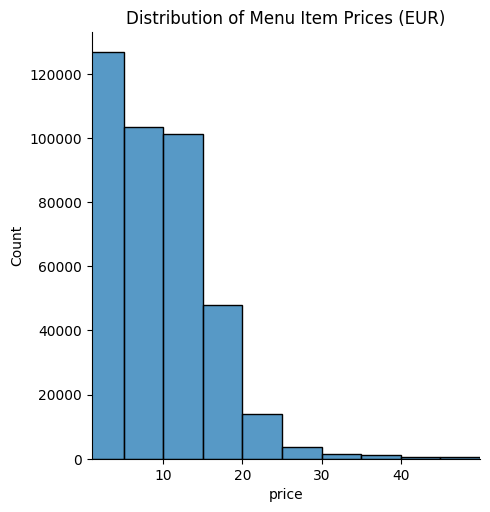

In [ ]:
# Distribution per EUR 5, up to EUR 100 (still including some outliers; best to limit to 60 EUR)
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data = price_item, x = "price", bins = 10)
plt.xlim(1, price_item["price"].max()) # gets rid off the space after 0
plt.title("Distribution of Menu Item Prices (EUR)")
plt.show()

4.2  What is the distribution of restaurants per location?

4.3 Which are the top 10 pizza restaurants by rating?

4.4 Map locations offering kapsalons (or your favorite dish) and their average price.

4.5 Which restaurants have the best price-to-rating ratio?

4.6 Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

4.7 How does the availability of vegetarian and vegan dishes vary by area?

4.8 Identify the World Hummus Order (WHO); top 3 hummus serving restaurants.